# Setup

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# folder name to save results
saving_dir_name = 'Human Detection'

# use 'toy' dataset with minimal number of samples
toy_data = False
toy_samples = 20

In [ ]:
saving_dir = os.path.join('/content/gdrive/MyDrive/', saving_dir_name)

if not os.path.exists(saving_dir):
    os.mkdir(saving_dir)

In [ ]:
# for computring mean average precision of detections
!pip install map-boxes

In [ ]:
!ls -lah "$saving_dir"

lrw------- 1 root root 0 Jan 12 12:32 '/content/gdrive/MyDrive/Human Detection' -> '/content/gdrive/.shortcut-targets-by-id/15OK9UaKG9LNNjvBvpNQqIoo3D_KZX8ZX/Human Detection'


# Definitions

## imports

In [ ]:
from typing import Union, TypedDict
from pathlib import Path
import multiprocessing
import xml.etree.ElementTree
import json
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tqdm import tqdm, trange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

import torchvision.models.vgg as vgg
import torchvision.datasets.voc as voc

from torchvision.ops import box_iou, roi_pool
from torchvision.transforms import v2 as T
from torchvision.tv_tensors import BoundingBoxes
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

import joblib
from sklearn.svm import LinearSVC
from skimage import color
from skimage.feature import hog
from skimage.transform import pyramid_gaussian
from imutils.object_detection import non_max_suppression

# metrics
from map_boxes import mean_average_precision_for_boxes
from sklearn.metrics import f1_score, classification_report

DS = Union[voc.VOCDetection, torch.utils.data.Subset]
cv2.setUseOptimized(True);
cv2.setNumThreads(multiprocessing.cpu_count());
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## plotting

In [ ]:
def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = T.functional.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = T.functional.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

## modeling

### R-CNN

In [ ]:
def init_weights(module: nn.Module):
    for m in module.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)


def make_header(in_features: int, hidden_features: int, out_feautures: int, dropout: float) -> nn.Module:
    return nn.Sequential(
        nn.Linear(in_features, hidden_features),
        nn.ReLU(True),
        nn.Dropout(p=dropout),
        nn.Linear(hidden_features, hidden_features),
        nn.ReLU(True),
        nn.Dropout(p=dropout),
        nn.Linear(hidden_features, out_feautures)
    )


class Classifier(nn.Module):
    def __init__(self, in_channels: int = 512, pool_size: int = 7, dropout: float = 0.5, num_classes=1):
        super().__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((pool_size, pool_size))
        self.header = make_header(in_channels * pool_size * pool_size, 4096, num_classes, dropout)
        init_weights(self)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.header(x)
        return x


class RCNN(nn.Module):
    def __init__(self,
                 encoder: nn.Module,
                 in_channels: int = 512, pool_size: int = 7, dropout: float = 0.5, num_classes=2):
        super().__init__()
        self.pool_size = pool_size
        self.encoder = encoder
        self.classifier = make_header(in_channels * pool_size * pool_size, 4096, num_classes, dropout)
        self.regressor = make_header(in_channels * pool_size * pool_size, 4096, num_classes*4, dropout)
        init_weights(self.classifier)
        init_weights(self.regressor)

    def forward(self, inputs: torch.Tensor, rois: list[torch.Tensor]):
        x = self.encoder(inputs)
        # print(x.shape, inputs.shape[2]/x.shape[2])
        x = roi_pool(x, rois, self.pool_size, spatial_scale=x.shape[2]/inputs.shape[2])
        x = torch.flatten(x, 1)
        cls = self.classifier(x)
        bbx = self.regressor(x)
        return cls, bbx


class MultiTaskLoss(nn.Module):
    def __init__(self, lambda_: float = 1):
        super().__init__()
        self._lambda = lambda_
        self.cls = nn.CrossEntropyLoss(reduction='none')
        self.loc = nn.SmoothL1Loss(reduction='none')

    def forward(self, input_logits, input_loc, target_cls, target_loc):
        # input_logits: [N, K] predicted classes logits
        # input_log   : [N, K*4] predicted per class location offsets
        # target_cls  : [N, K] target class lables
        # target_loc  : [N, 4] target class offsets
        not_background = (target_cls[:, 0] == 0).type(input_logits.dtype)
        input_cls_idx = target_cls.argmax(dim=1)
        input_cls_loc = torch.concat([
            input_loc[[i], cls_idx*4: (cls_idx+1)*4] for i, cls_idx in enumerate(input_cls_idx)
        ])
        cls = self.cls(input_logits, target_cls)
        loc = self.loc(input_cls_loc, target_loc).sum(1)
        return (cls + self._lambda * not_background * loc).mean()





## data




### voc preprocessing

In [ ]:
voc_lables = [
    'aeroplane',
    'bicycle',
    'bird',
    'boat',
    'bottle',
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'diningtable',
    'dog',
    'horse',
    'motorbike',
    'person',
    'pottedplant',
    'sheep',
    'sofa',
    'train',
    'tvmonitor'
]

person_idx = voc_lables.index('person')

def annotation_to_target(ann: dict, lables: list[str] | None = None):
    w = int(ann['size']['width'])
    h = int(ann['size']['height'])
    b_arr = []
    l_arr = []
    d_arr = []
    for obj in ann['object']:
        if lables is not None and obj['name'] not in lables:
            continue
        b_arr.append([int(obj['bndbox'][k]) for k in ['xmin', 'ymin', 'xmax', 'ymax']])
        l_arr.append(voc_lables.index(obj['name']))
        d_arr.append(int(int(obj['truncated']) or int(obj['occluded']) or int(obj['difficult'])))
    bboxes = BoundingBoxes(b_arr, format='XYXY', canvas_size=(h, w))
    return bboxes, torch.tensor(l_arr), torch.tensor(d_arr)


class AnnotationToTarget(nn.Module):
    def forward(self, img, target):
        return img, annotation_to_target(target['annotation'])


class BoxesToArray(nn.Module):
    def forward(self, img, target: tuple[BoundingBoxes, torch.Tensor]):
        bboxes, labels = target
        boxes = bboxes.data
        boxes[:, [0, 2]] / bboxes.canvas_size[1]
        boxes[:, [1, 3]] / bboxes.canvas_size[0]
        return img, (boxes, labels)


def make_transforms(transforms: list) -> T.Compose:
    return T.Compose([
        # AnnotationToTarget(),
        *(transforms or []),
        T.PILToTensor(),
        T.ConvertImageDtype(torch.float),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

### RoI computing

In [ ]:
def get_item(ds: DS, index: int, lables: list[str] | str = None, pil=False, load_im=True, difficulties=False):
    if not isinstance(ds, voc.VOCDetection):
        ds = ds.dataset
    path = ds.images[index]
    im = None
    if load_im:
        im = Image.open(path) if pil else cv2.imread(path)
    target = ds.parse_voc_xml(
        xml.etree.ElementTree.parse(ds.annotations[index]).getroot()
    )
    target = annotation_to_target(
        target['annotation'],
        lables=lables
    )
    if not difficulties:
        target = target[:2]
    return (
        path,
        im,
        *target
    )


def item_rois(im, quality=False):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(im)
    if quality:
        ss.switchToSelectiveSearchQuality()
    else:
        ss.switchToSelectiveSearchFast()

    rois = ss.process() # x, y, w, h
    rois[:, 2] += rois[:, 0] # x += w
    rois[:, 3] += rois[:, 1] # y += h
    rois = torch.tensor(rois)
    return rois


class ROIsDict(TypedDict):
    filepath:        str
    shape:           tuple[int, int]
    human_bboxes:    list[tuple[int, int, int, int]]
    human_rois:      list[tuple[int, int, int, int, int]]
    background_rois: list[tuple[int, int, int, int]]


def generate_roi_samples(ds: DS, i: int) -> ROIsDict | None:
    path, im, bboxes, lables = get_item(ds, i, ['person'])
    if not len(lables): # no humans
        return
    rois = item_rois(im)
    ious = box_iou(bboxes.data, rois).T
    thresholded = (ious < 0.5).all(axis=1)
    background_rois = rois[thresholded]
    return {
        'filepath': path,
        'shape': im.shape[:2],
        'human_bboxes': bboxes.tolist(),
        'human_rois': torch.concat([
            rois[~thresholded],                               # roi bboxes
            ious[~thresholded].argmax(axis=1, keepdims=True)  # index of target human box
        ], axis=1).tolist(),
        'background_rois': background_rois.tolist(),
    }

def _run(inp):
    ds, b, e = inp
    result = []
    for i in trange(b, e, desc=f'{b}:{e}'):
        if (samples := generate_roi_samples(ds, i)):
            result.append(samples)
    return result

def run_multiproc(ds: DS):
    n = multiprocessing.cpu_count()
    h = len(ds) // n
    with multiprocessing.Pool(processes=n) as pool:
        result = []
        for r in pool.map(_run, [(ds, i*h, (i+1)*h) for i in range(n-1)] + [(ds, (n-1)*h, len(ds))]):
            result += r
    return result

def get_ds_rois(ds: DS, fn: str):
    if not os.path.exists(fn):
        rois = run_multiproc(ds)
        with open(fn, 'w') as f:
            json.dump(rois, f)
    else:
        with open(fn, 'r') as f:
            rois = json.load(f)
    return rois


### RoI dataset

In [ ]:
ROISample = tuple[Image.Image, tuple[BoundingBoxes, BoundingBoxes, BoundingBoxes]]
# image, [neg, pos, target]

class ROIDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            rois: list[ROIsDict],
            total_rois: int = 64, # number of rois in resulted sample
            pos_proposals_ratio: float = 0.25, # precentage of total availabe positive rois
                                               # (with human) to use in sample
            balanced_rois: bool = False, # ignore pos_proposals_ratio and try to
                                         # include same amount of negative and positive rois
            transforms: T.Transform = None,
            ) -> None:
        super().__init__()
        # TODO: remove this filtering and increase number of positive rois
        # or ensure there is at least one for each target bbox
        self.rois = [x for x in rois if x['human_rois']]
        self.total_rois = total_rois
        self.pos_proposals_ratio = pos_proposals_ratio
        self.balanced_rois = balanced_rois
        self.transforms = transforms or T.Transform()

    def select_random(self, data: ROIsDict) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        data['human_bboxes'] = np.asarray(data['human_bboxes'])
        data['human_rois'] = np.asarray(data['human_rois'])
        data['background_rois'] = np.asarray(data['background_rois'])
        data['shape'] = tuple(data['shape'])

        pos_n = len(data['human_rois'])
        neg_n = len(data['background_rois'])

        pos_select = (
            self.total_rois // 2
            if self.balanced_rois
            else int(pos_n * self.pos_proposals_ratio)
        )
        # TODO: maybe we should pass batches without positive rois?
        if not pos_select:
            pos_select = pos_n
        pos_rois = data['human_rois'][
            np.random.choice(
                list(range(pos_n)),
                min(pos_select, pos_n)
            ).tolist()
        ]
        pos_targets = data['human_bboxes'][pos_rois[:, 4]]
        pos_rois = pos_rois[:, :4]

        neg_rois = data['background_rois'][
            np.random.choice(
                list(range(neg_n)),
                max(self.total_rois - len(pos_rois), 0)
            ).tolist()
        ]
        return neg_rois, pos_rois, pos_targets

    def get_base(self, index) -> ROISample:
        data = self.rois[index]
        im = Image.open(data['filepath']).convert("RGB")
        target = [
            BoundingBoxes(data=bboxes, canvas_size=data['shape'], format='XYXY')
            for bboxes in self.select_random(data)
        ]
        return im, target

    def __len__(self):
        return len(self.rois)


class ROIClassifierDataset(ROIDataset):
    def __getitem__(self, index) -> tuple[list[torch.Tensor], torch.Tensor]:
        im, (neg, pos, _) = self.get_base(index)
        target = torch.zeros(len(neg)+len(pos))
        target[-len(pos):] = 1
        return (
            [
                self.transforms(im.crop((x1,y1,x2,y2)))
                for (x1,y1,x2,y2) in (
                    neg.data.type(torch.int32).tolist() +
                    pos.data.type(torch.int32).tolist()
                )
            ],
            target
        )

    def collate(self, batch: list[tuple[list[torch.Tensor], torch.Tensor]]):
        images = []
        lables = []
        for imgs, targets in batch:
            images += imgs
            lables += [targets]
        return torch.stack(images), torch.concat(lables)


class ROIDetectionDataset(ROIDataset):
    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        im, (neg, pos, target) = self.transforms(*self.get_base(index))
        lables = torch.zeros(len(neg)+len(pos), 2)
        lables[:len(neg), 0] = 1
        lables[-len(pos):, 1] = 1
        bboxes = torch.zeros(len(neg)+len(pos), 4)
        bboxes[-len(pos):] = target.data - pos.data
        rois = torch.concat([neg.data, pos.data])
        return (
            im, rois, bboxes, lables
        )

    def collate(self, batch: list[tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]]):
        sizes = []
        images = []
        rois = []
        bboxes = []
        lables = []
        for img, roi, bbx, lbl in batch:
            images += [img]
            sizes += [list(img.shape[1:])]
            rois += [roi]
            bboxes += [bbx]
            lables += [lbl]
        sizes = np.asarray(sizes)
        h = sizes[:, 0].max()
        w = sizes[:, 1].max()
        return (
            torch.stack([F.pad(img, (0, w-img.shape[2], 0, h-img.shape[1])) for img in images]),
            rois,
            torch.concat(bboxes),
            torch.concat(lables)
        )



In [ ]:
train_cls_transforms = make_transforms([
    # T.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.)), # TODO: throws error when roi is too small
    T.RandomHorizontalFlip(p=0.5),
    T.Resize(size=(224, 224), antialias=True),
])

valid_cls_transforms = make_transforms([
    T.Resize(size=(224, 224), antialias=True),
])

train_det_transforms = make_transforms([
    # T.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.)),
    T.RandomHorizontalFlip(p=0.5),
])

valid_det_transforms = make_transforms([
])

In [ ]:
common_ds = dict(
    root='./VOC', year='2012', download=not os.path.isdir('./VOC/ImageSets')
)

train_voc = voc.VOCDetection(**common_ds, image_set='train')
valid_voc = voc.VOCDetection(**common_ds, image_set='val')

if toy_data:
    train_voc = torch.utils.data.Subset(train_voc, list(range(toy_samples)))
    valid_voc = torch.utils.data.Subset(valid_voc, list(range(toy_samples)))

Using downloaded and verified file: ./VOC/VOCtrainval_11-May-2012.tar
Extracting ./VOC/VOCtrainval_11-May-2012.tar to ./VOC
Using downloaded and verified file: ./VOC/VOCtrainval_11-May-2012.tar
Extracting ./VOC/VOCtrainval_11-May-2012.tar to ./VOC


In [ ]:
train_rois_fn = os.path.join(saving_dir, f"train_rois_v2{('_toy') if toy_data else ''}.json")
train_rois = get_ds_rois(train_voc, train_rois_fn)

valid_rois_fn = os.path.join(saving_dir, f"valid_rois_v2{('_toy') if toy_data else ''}.json")
valid_rois = get_ds_rois(valid_voc, valid_rois_fn)

# Fast R-CNN

In [ ]:
vgg_type = 'D'
encoder = nn.Sequential(*vgg.make_layers(vgg.cfgs[vgg_type], batch_norm=True))
classifier = Classifier(dropout=0.5, num_classes=1)

backbone = nn.Sequential(encoder, classifier).to(device)
backbone_fn = os.path.join(saving_dir, f"backbone_{vgg_type}{('_toy') if toy_data else ''}.pt")


In [ ]:
rcnn = RCNN(backbone[0]).to(device)
bb_name = Path(backbone_fn).with_suffix('').name
rcnn_fn = os.path.join(saving_dir, f"rcnn_bs2_{bb_name}.pt")

## Pretraining encoder

In [ ]:
class ClassifierVOCDataset(torch.utils.data.Dataset):
    def __init__(self, voc_ds, tr):
        self.tr = tr
        self.ds = voc_ds
        self.files = []
        self.bboxes = []
        self.lables = []
        # self.images = {}
        for i in range(len(self.ds)):
            path, _, bboxes, lables = get_item(self.ds, i, load_im=False)
            n = lables.shape[0]
            # self.images[path] = im
            self.files += [path]*n
            self.bboxes += bboxes.data.tolist()
            self.lables += (lables == person_idx).type(torch.int32).tolist()

    def __len__(self):
        return len(self.bboxes)

    def __getitem__(self, i):
        # im = self.images[self.files[i]].copy()
        im = Image.open(self.files[i])
        inputs = self.tr(im.crop(self.bboxes[i]))
        return inputs, float(self.lables[i])

In [ ]:
def evaluate_v2(model, dl, criterion, epoch=0):
    running_loss = 0.0
    running_count = 0
    pred_labels = []
    true_labels = []
    validation = tqdm(dl)
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(validation):
            outputs = model(inputs.to(device))
            loss = criterion(outputs.flatten(), labels.to(device))
            running_loss += loss.item()
            running_count += 1
            validation.set_description(
                f'[{epoch + 1}] valid_loss: {(loss := running_loss / running_count):.3f}'
            )
            true_labels += labels.cpu().type(torch.int32).tolist()
            pred_labels += (
                F.sigmoid(outputs.flatten().cpu()) > 0.5
            ).type(torch.int32).tolist()
            if i == len(dl)-1:
                pred_labels = np.array(pred_labels)
                true_labels = np.array(true_labels)
                acc = (true_labels == pred_labels).mean()
                f1 = f1_score(true_labels, pred_labels)
                validation.set_description(
                    f'[{epoch + 1}] valid_loss: {loss:.3f} f1: {f1:.3f} acc: {acc:.3f}'
                )
    return {
        'loss': loss, 'acc': acc, 'f1':f1
    }

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(backbone.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
batch_size = 2 if toy_data else 64

train_ds = ClassifierVOCDataset(
    voc_ds=train_voc,
    tr=train_cls_transforms
)

human_prob = np.array(train_ds.lables).mean()
weights = torch.tensor([[human_prob, 1-human_prob][y] for y in train_ds.lables])
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
# np.mean([train_ds.lables[i] for i in list(sampler)])

train_dl = torch.utils.data.DataLoader(
    dataset=train_ds,
    batch_size=batch_size,
    shuffle=False,
    sampler=sampler,
    num_workers=1#multiprocessing.cpu_count()
)

valid_ds = ClassifierVOCDataset(
    voc_ds=valid_voc,
    tr=valid_cls_transforms
)

valid_dl = torch.utils.data.DataLoader(
    dataset=valid_ds,
    batch_size=batch_size*2,
    shuffle=False,
    num_workers=1#multiprocessing.cpu_count()
)

best_loss = np.inf
for epoch in range(100):
    backbone.train()
    running_loss = 0.0
    running_count = 0
    training = tqdm(train_dl)
    for inputs, labels in training:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        outputs = backbone(inputs)
        loss = criterion(outputs.flatten(), labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_count += 1
        training.set_description(
            f'[{epoch + 1}] train_loss: {(train_loss := running_loss / running_count):.3f}'
        )
    backbone.eval()
    valid_loss = evaluate_v2(backbone, valid_dl, criterion, epoch)['loss']
    scheduler.step(valid_loss)
    if valid_loss < best_loss:
        print('saved to ', backbone_fn)
        best_loss = valid_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': backbone.state_dict(),
            # 'optimizer_state_dict': optimizer.state_dict(),
            'valid_loss': valid_loss,
        }, backbone_fn)

print('Finished Training')

[1] valid_loss: 0.457 f1: 0.646 acc: 0.787: 100%|██████████| 124/124 [01:56<00:00,  1.07it/s]


saved to  /content/gdrive/MyDrive/Human Detection/backbone_D.pt


[2] valid_loss: 0.428 f1: 0.712 acc: 0.805: 100%|██████████| 124/124 [01:55<00:00,  1.08it/s]


saved to  /content/gdrive/MyDrive/Human Detection/backbone_D.pt


[3] valid_loss: 0.396 f1: 0.755 acc: 0.825: 100%|██████████| 124/124 [01:46<00:00,  1.17it/s]


saved to  /content/gdrive/MyDrive/Human Detection/backbone_D.pt


[4] valid_loss: 0.367 f1: 0.757 acc: 0.831: 100%|██████████| 124/124 [01:50<00:00,  1.12it/s]


saved to  /content/gdrive/MyDrive/Human Detection/backbone_D.pt


[5] valid_loss: 0.366 f1: 0.762 acc: 0.838: 100%|██████████| 124/124 [01:49<00:00,  1.13it/s]


saved to  /content/gdrive/MyDrive/Human Detection/backbone_D.pt


[6] valid_loss: 0.341 f1: 0.767 acc: 0.854: 100%|██████████| 124/124 [01:54<00:00,  1.08it/s]


saved to  /content/gdrive/MyDrive/Human Detection/backbone_D.pt


[8] valid_loss: 0.321 f1: 0.782 acc: 0.865: 100%|██████████| 124/124 [01:50<00:00,  1.12it/s]


saved to  /content/gdrive/MyDrive/Human Detection/backbone_D.pt


[13] train_loss: 0.198:  16%|█▌        | 39/247 [00:23<02:03,  1.68it/s]


KeyboardInterrupt: 

## Training RCNN

In [ ]:
anns_df = pd.DataFrame()
for data in valid_rois:
    ann_bboxes = np.array(data['human_bboxes'])
    ann_df = pd.DataFrame({
        'XMin': ann_bboxes[:,0],
        'YMin': ann_bboxes[:,1],
        'XMax': ann_bboxes[:,2],
        'YMax': ann_bboxes[:,3],
    })
    ann_df['ImageID'] = data['filepath']
    anns_df = pd.concat([anns_df, ann_df])
anns_df['LabelName'] = 'person'

In [ ]:
def collect_dets(model, rois_data, tr, thr=0):
    validation = tqdm(rois_data)
    dets_df = pd.DataFrame()
    with torch.no_grad():
        for i, data in enumerate(validation):
            inputs = torch.unsqueeze(tr(Image.open(data['filepath'])), 0)
            roi_bboxes = torch.tensor(
                [bbox[:4] for bbox in data['human_rois']] + data['background_rois']
            ).type(torch.float)

            output_logits, output_loc = model(inputs.to(device), [roi_bboxes.to(device)])

            output_probas = F.softmax(output_logits.cpu(), 1)
            humans_mask = output_probas[:, 1] > thr
            bboxes = roi_bboxes[humans_mask].cpu() + output_loc[humans_mask, 4:].cpu()
            confs = output_probas[humans_mask, 1]
            order = (1-confs).argsort()
            confs = confs[order]
            bboxes = torch.round(bboxes[order]).type(torch.int32)

            df = pd.DataFrame({
                'Conf': confs.numpy(),
                'XMin': bboxes[:,0].numpy(),
                'YMin': bboxes[:,1].numpy(),
                'XMax': bboxes[:,2].numpy(),
                'YMax': bboxes[:,3].numpy(),
            })
            df['ImageID'] = data['filepath']
            df['LabelName'] = 'person'
            dets_df = pd.concat([dets_df, df])

    return dets_df

In [ ]:
backbone_state = torch.load(backbone_fn, map_location=device)
backbone.load_state_dict(backbone_state['model_state_dict'])
backbone_state['epoch'], backbone_state['valid_loss']

(7, 0.3208733137193937)

In [ ]:
criterion = MultiTaskLoss()
optimizer = optim.SGD(rcnn.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')
batch_size = 2

# for param in rcnn.encoder.parameters():
#     param.requires_grad = False

train_ds = ROIDetectionDataset(
    rois=train_rois,
    balanced_rois=toy_data,
    total_rois=2 if toy_data else 64,
    pos_proposals_ratio=0.25,
    transforms=train_det_transforms
)

train_dl = torch.utils.data.DataLoader(
    dataset=train_ds,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=train_ds.collate,
    num_workers=multiprocessing.cpu_count()
)

best_map = -np.inf
for epoch in range(100):
    running_loss = 0.0
    running_count = 0
    training = tqdm(train_dl)
    for inputs, rois, target_loc, target_cls in training:
        optimizer.zero_grad()
        output_logits, output_loc = rcnn(inputs.to(device), [x.to(device) for x in rois])
        loss = criterion(output_logits, output_loc, target_cls.to(device), target_loc.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_count += 1
        training.set_description(
            f'[{epoch + 1}] train_loss: {(train_loss := running_loss / running_count):.3f}'
        )
    dets_df = collect_dets(rcnn, valid_rois, valid_det_transforms, 0.3)
    map, _ = mean_average_precision_for_boxes(
        anns_df[['ImageID', 'LabelName', 'XMin', 'XMax', 'YMin', 'YMax']].values,
        dets_df[['ImageID', 'LabelName', 'Conf', 'XMin', 'XMax', 'YMin', 'YMax']].values,
        verbose=True
    )
    scheduler.step(map)
    if map > best_map:
        print('saved to ', rcnn_fn)
        best_map = map
        torch.save({
            'epoch': epoch,
            'model_state_dict': rcnn.state_dict(),
            # 'optimizer_state_dict': optimizer.state_dict(),
            'valid_map': map,
        }, rcnn_fn)

print('Finished Training')

100%|██████████| 2232/2232 [03:20<00:00, 11.12it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.050907 |    5110
mAP: 0.050907
saved to  /content/gdrive/MyDrive/Human Detection/rcnn_bs2_backbone_D.pt


100%|██████████| 2232/2232 [03:11<00:00, 11.66it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.065881 |    5110
mAP: 0.065881
saved to  /content/gdrive/MyDrive/Human Detection/rcnn_bs2_backbone_D.pt


100%|██████████| 2232/2232 [03:10<00:00, 11.73it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.060215 |    5110
mAP: 0.060215


100%|██████████| 2232/2232 [03:10<00:00, 11.71it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.066472 |    5110
mAP: 0.066472
saved to  /content/gdrive/MyDrive/Human Detection/rcnn_bs2_backbone_D.pt


100%|██████████| 2232/2232 [03:11<00:00, 11.64it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.063757 |    5110
mAP: 0.063757


100%|██████████| 2232/2232 [03:10<00:00, 11.69it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.065385 |    5110
mAP: 0.065385


100%|██████████| 2232/2232 [03:13<00:00, 11.55it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.068983 |    5110
mAP: 0.068983
saved to  /content/gdrive/MyDrive/Human Detection/rcnn_bs2_backbone_D.pt


100%|██████████| 2232/2232 [03:11<00:00, 11.67it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.061949 |    5110
mAP: 0.061949


100%|██████████| 2232/2232 [03:11<00:00, 11.67it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.066306 |    5110
mAP: 0.066306


100%|██████████| 2232/2232 [03:10<00:00, 11.73it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.068920 |    5110
mAP: 0.068920


100%|██████████| 2232/2232 [03:11<00:00, 11.65it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.067189 |    5110
mAP: 0.067189


100%|██████████| 2232/2232 [03:13<00:00, 11.53it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.074292 |    5110
mAP: 0.074292
saved to  /content/gdrive/MyDrive/Human Detection/rcnn_bs2_backbone_D.pt


100%|██████████| 2232/2232 [03:13<00:00, 11.54it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.074672 |    5110
mAP: 0.074672
saved to  /content/gdrive/MyDrive/Human Detection/rcnn_bs2_backbone_D.pt


100%|██████████| 2232/2232 [03:12<00:00, 11.62it/s]


Number of files in annotations: 2232
Number of files in predictions: 2231
Unique classes: 1
Detections length: 2231
Annotations length: 2232
person                         | 0.072030 |    5110
mAP: 0.072030


100%|██████████| 2232/2232 [03:12<00:00, 11.57it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.072888 |    5110
mAP: 0.072888


100%|██████████| 2232/2232 [03:13<00:00, 11.54it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.075544 |    5110
mAP: 0.075544
saved to  /content/gdrive/MyDrive/Human Detection/rcnn_bs2_backbone_D.pt


100%|██████████| 2232/2232 [03:15<00:00, 11.42it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.075596 |    5110
mAP: 0.075596
saved to  /content/gdrive/MyDrive/Human Detection/rcnn_bs2_backbone_D.pt


100%|██████████| 2232/2232 [03:13<00:00, 11.53it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.075224 |    5110
mAP: 0.075224


100%|██████████| 2232/2232 [03:13<00:00, 11.51it/s]


Number of files in annotations: 2232
Number of files in predictions: 2231
Unique classes: 1
Detections length: 2231
Annotations length: 2232
person                         | 0.077488 |    5110
mAP: 0.077488
saved to  /content/gdrive/MyDrive/Human Detection/rcnn_bs2_backbone_D.pt


100%|██████████| 2232/2232 [03:13<00:00, 11.51it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.077176 |    5110
mAP: 0.077176


100%|██████████| 2232/2232 [03:13<00:00, 11.51it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.073636 |    5110
mAP: 0.073636


100%|██████████| 2232/2232 [03:15<00:00, 11.43it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.075814 |    5110
mAP: 0.075814


100%|██████████| 2232/2232 [03:13<00:00, 11.52it/s]


Number of files in annotations: 2232
Number of files in predictions: 2231
Unique classes: 1
Detections length: 2231
Annotations length: 2232
person                         | 0.076560 |    5110
mAP: 0.076560


100%|██████████| 2232/2232 [03:15<00:00, 11.41it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.083179 |    5110
mAP: 0.083179
saved to  /content/gdrive/MyDrive/Human Detection/rcnn_bs2_backbone_D.pt


100%|██████████| 2232/2232 [03:15<00:00, 11.42it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.084939 |    5110
mAP: 0.084939
saved to  /content/gdrive/MyDrive/Human Detection/rcnn_bs2_backbone_D.pt


100%|██████████| 2232/2232 [03:12<00:00, 11.58it/s]


Number of files in annotations: 2232
Number of files in predictions: 2231
Unique classes: 1
Detections length: 2231
Annotations length: 2232
person                         | 0.085427 |    5110
mAP: 0.085427
saved to  /content/gdrive/MyDrive/Human Detection/rcnn_bs2_backbone_D.pt


100%|██████████| 2232/2232 [03:14<00:00, 11.46it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.086007 |    5110
mAP: 0.086007
saved to  /content/gdrive/MyDrive/Human Detection/rcnn_bs2_backbone_D.pt


100%|██████████| 2232/2232 [03:14<00:00, 11.48it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.091131 |    5110
mAP: 0.091131
saved to  /content/gdrive/MyDrive/Human Detection/rcnn_bs2_backbone_D.pt


100%|██████████| 2232/2232 [03:14<00:00, 11.47it/s]


Number of files in annotations: 2232
Number of files in predictions: 2231
Unique classes: 1
Detections length: 2231
Annotations length: 2232
person                         | 0.078685 |    5110
mAP: 0.078685


100%|██████████| 2232/2232 [03:13<00:00, 11.52it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.078697 |    5110
mAP: 0.078697


100%|██████████| 2232/2232 [03:12<00:00, 11.57it/s]


Number of files in annotations: 2232
Number of files in predictions: 2231
Unique classes: 1
Detections length: 2231
Annotations length: 2232
person                         | 0.080436 |    5110
mAP: 0.080436


100%|██████████| 2232/2232 [03:13<00:00, 11.53it/s]


Number of files in annotations: 2232
Number of files in predictions: 2231
Unique classes: 1
Detections length: 2231
Annotations length: 2232
person                         | 0.086474 |    5110
mAP: 0.086474


100%|██████████| 2232/2232 [03:14<00:00, 11.50it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.084345 |    5110
mAP: 0.084345


100%|██████████| 2232/2232 [03:14<00:00, 11.49it/s]


Number of files in annotations: 2232
Number of files in predictions: 2231
Unique classes: 1
Detections length: 2231
Annotations length: 2232
person                         | 0.085608 |    5110
mAP: 0.085608


100%|██████████| 2232/2232 [03:15<00:00, 11.42it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.083079 |    5110
mAP: 0.083079


100%|██████████| 2232/2232 [03:14<00:00, 11.48it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.092242 |    5110
mAP: 0.092242
saved to  /content/gdrive/MyDrive/Human Detection/rcnn_bs2_backbone_D.pt


100%|██████████| 2232/2232 [03:14<00:00, 11.49it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.081609 |    5110
mAP: 0.081609


100%|██████████| 2232/2232 [03:13<00:00, 11.54it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.086034 |    5110
mAP: 0.086034


100%|██████████| 2232/2232 [03:14<00:00, 11.50it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.083234 |    5110
mAP: 0.083234


100%|██████████| 2232/2232 [03:16<00:00, 11.36it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.095322 |    5110
mAP: 0.095322
saved to  /content/gdrive/MyDrive/Human Detection/rcnn_bs2_backbone_D.pt


100%|██████████| 2232/2232 [03:14<00:00, 11.48it/s]


Number of files in annotations: 2232
Number of files in predictions: 2230
Unique classes: 1
Detections length: 2230
Annotations length: 2232
person                         | 0.081194 |    5110
mAP: 0.081194


100%|██████████| 2232/2232 [03:13<00:00, 11.54it/s]


Number of files in annotations: 2232
Number of files in predictions: 2228
Unique classes: 1
Detections length: 2228
Annotations length: 2232
person                         | 0.081456 |    5110
mAP: 0.081456


100%|██████████| 2232/2232 [03:14<00:00, 11.49it/s]


Number of files in annotations: 2232
Number of files in predictions: 2230
Unique classes: 1
Detections length: 2230
Annotations length: 2232
person                         | 0.088722 |    5110
mAP: 0.088722


100%|██████████| 2232/2232 [03:14<00:00, 11.45it/s]


Number of files in annotations: 2232
Number of files in predictions: 2232
Unique classes: 1
Detections length: 2232
Annotations length: 2232
person                         | 0.087210 |    5110
mAP: 0.087210


100%|██████████| 2232/2232 [03:14<00:00, 11.46it/s]


Number of files in annotations: 2232
Number of files in predictions: 2231
Unique classes: 1
Detections length: 2231
Annotations length: 2232
person                         | 0.089976 |    5110
mAP: 0.089976


100%|██████████| 2232/2232 [03:15<00:00, 11.43it/s]


Number of files in annotations: 2232
Number of files in predictions: 2231
Unique classes: 1
Detections length: 2231
Annotations length: 2232
person                         | 0.087491 |    5110
mAP: 0.087491


 78%|███████▊  | 1746/2232 [02:29<00:41, 11.71it/s]


KeyboardInterrupt: 

## Runtime

In [ ]:
rcnn_state = torch.load(rcnn_fn, map_location=device)
rcnn.load_state_dict(rcnn_state['model_state_dict'])
rcnn_state['epoch'], rcnn_state['valid_map']

(39, 0.09532211845833818)

In [ ]:
def fast_rcnn(path,thr = 0.95,overlap_thr = 0.3,):
    im = Image.open(path).convert('RGB')
    rois = item_rois(np.asarray(im), quality=True).type(torch.float32).to(device)
    inputs = valid_det_transforms(im)
    with torch.no_grad():
        output_logits, output_loc = rcnn(torch.unsqueeze(inputs.to(device), 0), [rois])
        confs = F.softmax(output_logits.cpu(), 1)[:, 1]
        boxes = torch.round(rois + output_loc[:, 4:]).type(torch.int32).cpu()
        valid = (boxes[:, 0] <= boxes[:, 2]) & (boxes[:, 1] <= boxes[:, 3])
        confs = confs[valid]
        boxes = boxes[valid]
        order = (1-confs).argsort()
        confs = confs[order]
        boxes = boxes[order]

    selected = non_max_suppression(
        boxes[confs > thr].numpy(),
        confs[confs > thr].numpy(),
        overlapThresh=overlap_thr
    )
    selected[:,0] = np.clip(selected[:,0], 0, im.width)
    selected[:,2] = np.clip(selected[:,2], 0, im.width)
    selected[:,1] = np.clip(selected[:,1], 0, im.height)
    selected[:,3] = np.clip(selected[:,3], 0, im.height)
    return im, selected

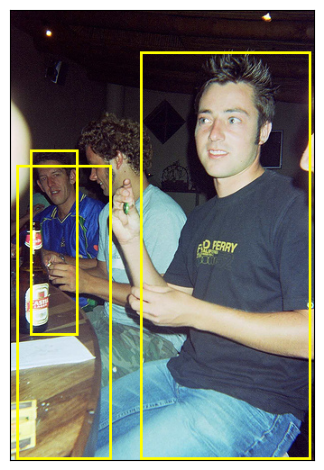

In [ ]:
im, selected = fast_rcnn(valid_voc.images[9])

plot([(
    im,
    BoundingBoxes(selected, format='XYXY', canvas_size=(im.width, im.height))
)])

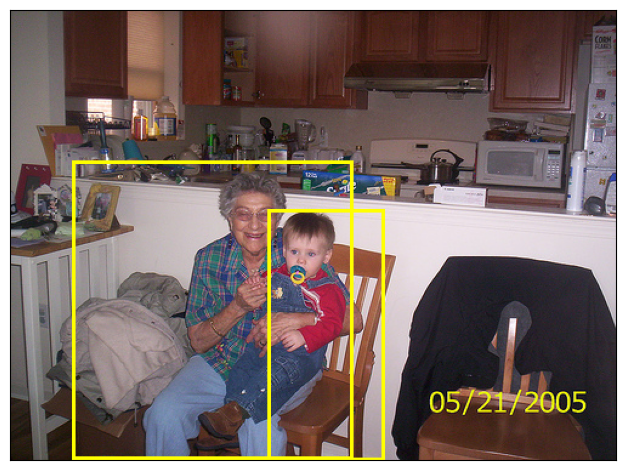

In [ ]:
im, boxes = fast_rcnn(valid_voc.images[13])

plot([(
    im,
    BoundingBoxes(boxes, format='XYXY', canvas_size=(im.width, im.height))
)])

# HOG

In [ ]:
# Define HOG parameters
winSize = (32, 96)
blockSize = (32, 32)
blockStride = (16, 16)
cellSize = (16, 16)
nbins = 9

# Create the HOG descriptor and the HOG from each image
hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)

## Training

In [ ]:
# def correct_bbox(xmin, xmax, ymin, ymax):
#     xcenter = (xmax + xmin) // 2
#     ycenter = (ymax + ymin) // 2
#     halfdim = min(xmax-xmin, ymax-ymin) // 2
#     xmin, xmax = xcenter-halfdim, xcenter+halfdim
#     ymin, ymax = ycenter-int(halfdim*3), ycenter+int(halfdim*3)
#     return max(xmin, 0), xmax,  max(ymin, 0), ymax

def correct_bbox(xmin, xmax, ymin, ymax):
    height = ymax - ymin
    width = height/3
    xcenter = (xmax + xmin) // 2
    ycenter = (ymax + ymin) // 2
    xmin, xmax = xcenter-int(width/2), xcenter+int(width/2)
    ymin, ymax = ycenter-int(height/2), ycenter+int(height/2)
    return max(xmin, 0), xmax,  max(ymin, 0), ymax


train_hog_data = []
train_hog_difficult = []
train_hog_lables = []

for i in trange(len(train_voc)):
    path, img, bboxes, lables, difficulties = get_item(train_voc, i, difficulties=True)
    humans = (lables == person_idx)

    if not len(humans) or not humans.any():
        # random bounding box: at least the target size to avoid scaling up
        height, width = img.shape[:2]
        if winSize[0] > min(height, width):
            continue
        boxsize = random.randint(winSize[0], min(height, width))
        x = random.randint(0, width-boxsize)
        y = random.randint(0, height-boxsize)
        sample = img[y:y+boxsize*3, x:x+boxsize]
        # assert tuple(sample.shape[:2]) == (boxsize, boxsize*3)
        sample = cv2.resize(sample, winSize)
        train_hog_data.append(sample) #hog.compute(sample).flatten())
        train_hog_lables.append(0)
        train_hog_difficult.append(0)
        continue

    for is_human, (xmin, ymin, xmax, ymax), difficult in zip(
            humans.tolist(), bboxes.data.tolist(), difficulties.tolist()
    ):
        if not is_human:
            continue
        xmin, xmax, ymin, ymax = correct_bbox(xmin, xmax, ymin, ymax)
        sample = img[ymin:ymax, xmin:xmax]
        sample = cv2.resize(sample, winSize)
        train_hog_data.append(sample) #hog.compute(sample).flatten())
        train_hog_lables.append(1)
        train_hog_difficult.append(difficult)

train_hog_data = np.stack(train_hog_data)
train_hog_lables = np.array(train_hog_lables)
train_hog_difficult = np.array(train_hog_difficult)

train_hog_lables.mean(), train_hog_difficult.mean()

100%|██████████| 5717/5717 [00:41<00:00, 137.20it/s]


(0.5840121014661391, 0.4839422853153363)

In [ ]:
positive = np.arange(len(train_hog_data))[(train_hog_difficult == 0) & (train_hog_lables == 1)].tolist()
negative = np.random.choice(
    np.arange(len(train_hog_data))[train_hog_lables == 0],
    len(positive), replace=False
).tolist()

train_hog_features = np.stack([hog.compute(train_hog_data[i]).flatten() for i in tqdm(positive+negative)])
train_hog_lables_subset = train_hog_lables[positive+negative]

In [ ]:
valid_hog_data = []
valid_hog_difficult = []
valid_hog_lables = []

for i in trange(len(valid_voc)):
    path, img, bboxes, lables, difficulties = get_item(valid_voc, i, difficulties=True)
    humans = (lables == person_idx)

    if not len(humans) or not humans.any():
        # random bounding box: at least the target size to avoid scaling up
        height, width = img.shape[:2]
        if winSize[0] > min(height, width):
            continue
        boxsize = random.randint(winSize[0], min(height, width))
        x = random.randint(0, width-boxsize)
        y = random.randint(0, height-boxsize)
        sample = img[y:y+boxsize*3, x:x+boxsize]
        # assert tuple(sample.shape[:2]) == (boxsize, boxsize*3)
        sample = cv2.resize(sample, winSize)
        valid_hog_data.append(sample) #hog.compute(sample).flatten())
        valid_hog_lables.append(0)
        valid_hog_difficult.append(0)
        continue

    for is_human, (xmin, ymin, xmax, ymax), difficult in zip(
            humans.tolist(), bboxes.data.tolist(), difficulties.tolist()
    ):
        if not is_human:
            continue
        xmin, xmax, ymin, ymax = correct_bbox(xmin, xmax, ymin, ymax)
        sample = img[ymin:ymax, xmin:xmax]
        sample = cv2.resize(sample, winSize)
        valid_hog_data.append(sample) #hog.compute(sample).flatten())
        valid_hog_lables.append(1)
        valid_hog_difficult.append(difficult)

valid_hog_data = np.stack(valid_hog_data)
valid_hog_lables = np.array(valid_hog_lables)
valid_hog_difficult = np.array(valid_hog_difficult)

train_hog_lables.mean(), train_hog_difficult.mean()

100%|██████████| 5823/5823 [00:55<00:00, 104.71it/s]


(0.5840121014661391, 0.4839422853153363)

In [ ]:
positive = np.arange(len(valid_hog_data))[(valid_hog_difficult == 0) & (valid_hog_lables == 1)].tolist()
negative = np.random.choice(
    np.arange(len(valid_hog_data))[valid_hog_lables == 0],
    len(positive), replace=False
).tolist()

valid_hog_features = np.stack([hog.compute(valid_hog_data[i]).flatten() for i in tqdm(positive+negative)])
valid_hog_lables_subset = valid_hog_lables[positive+negative]

100%|██████████| 1800/1800 [00:00<00:00, 2468.33it/s]


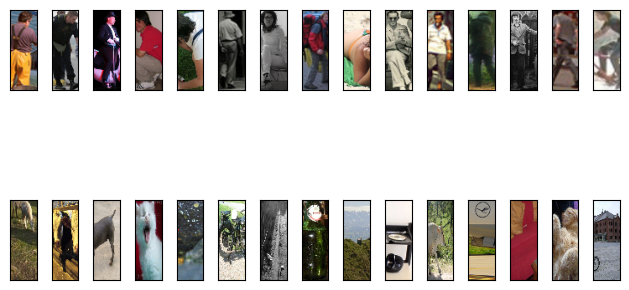

In [ ]:
n = 15
fig, axs = plt.subplots(2, n)
targets = np.random.choice(
    np.arange(len(train_hog_data))[(train_hog_difficult == 0) & (train_hog_lables == 1)],
    n, replace=False
)
for i, x in enumerate(train_hog_data[targets]):
    axs[0, i].imshow(x[:,:,::-1])
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
targets = np.random.choice(
    np.arange(len(train_hog_data))[(train_hog_lables == 0)],
    n
)
for i, x in enumerate(train_hog_data[targets]):
    axs[1, i].imshow(x[:,:,::-1])
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_RBF)
svm.setTermCriteria((
    cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS,
    100000,
    1e-8
))

svm.train(train_hog_features, cv2.ml.ROW_SAMPLE, train_hog_lables_subset)


# Save the SVM model
svm.save(os.path.join(saving_dir,'svm_model.yml'))
print(svm.getSupportVectors())

[[0.22728872 0.22728872 0.22728872 ... 0.13954276 0.14119421 0.14766128]
 [0.04002863 0.08151142 0.12697536 ... 0.13694362 0.12805226 0.10616283]
 [0.06993566 0.13520679 0.23800693 ... 0.11804724 0.13924533 0.22766416]
 ...
 [0.16983046 0.10950547 0.11042836 ... 0.1031761  0.12446166 0.1848636 ]
 [0.17421609 0.19617644 0.20707534 ... 0.20476723 0.20476723 0.19660354]
 [0.33804938 0.33804938 0.33804938 ... 0.017948   0.04552512 0.11078364]]


In [ ]:
_, valid_preds = svm.predict(valid_hog_features)
valid_preds = (valid_preds > 0.5).flatten().astype(int)
acc = (valid_hog_lables_subset == valid_preds).mean()
f1 = f1_score(valid_hog_lables_subset, valid_preds)
acc, f1

(0.8322222222222222, 0.8270332187857962)

## Testing

In [ ]:
svm = cv2.ml.SVM_load(os.path.join(saving_dir,'svm_model.yml'))
hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
hog.setSVMDetector(svm.getSupportVectors()[0])

In [ ]:
def hog_svm(path, scales=(0.2, 0.2, 0.4), thr=4.3, overlap_thr=0.3):
    img = cv2.imread(path)
    all_boxes = []
    all_weights = []
    for scale in scales:
        scaled = cv2.resize(img, (int(scale*img.shape[1]), int(scale*img.shape[0])))
        locs, weights = hog.detect(scaled, thr)
        if not len(locs):
            continue
        all_boxes.append(np.concatenate([locs/scale, (locs + winSize)/scale], axis=1))
        all_weights.append(weights)

    all_weights = np.concatenate(all_weights)
    all_boxes = np.concatenate(all_boxes)

    selected = non_max_suppression(
        all_boxes,
        all_weights,
        overlapThresh=overlap_thr
    )
    selected[:,0] = np.clip(selected[:,0], 0, img.shape[1])
    selected[:,2] = np.clip(selected[:,2], 0, img.shape[1])
    selected[:,1] = np.clip(selected[:,1], 0, img.shape[0])
    selected[:,3] = np.clip(selected[:,3], 0, img.shape[0])
    return img, selected

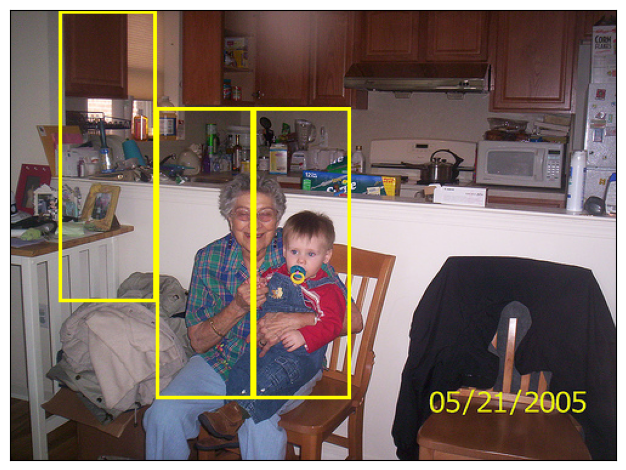

In [ ]:
im, boxes = hog_svm(valid_voc.images[13], overlap_thr=0.1, thr=4.4)
plot([(
    im[:,:,[2,1,0]],
    BoundingBoxes(boxes, format='XYXY', canvas_size=im.shape[:2])
)])

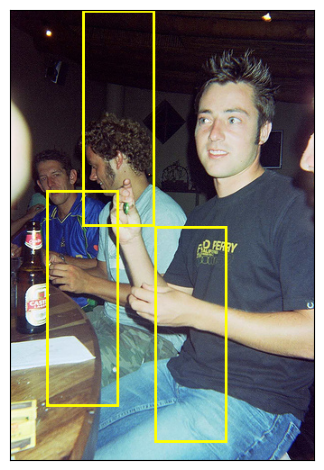

In [ ]:
im, boxes = hog_svm(valid_voc.images[9], overlap_thr=0.1, thr=4.40)
plot([(
    im[:,:,[2,1,0]],
    BoundingBoxes(boxes, format='XYXY', canvas_size=im.shape[:2])
)])